[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  7 of 7 completed
GMVP 1Q 2023 Returns: 40.40%
MSRP 1Q 2023 Returns: 70.11%
S&P 500 1Q 2023 Returns: 7.54%


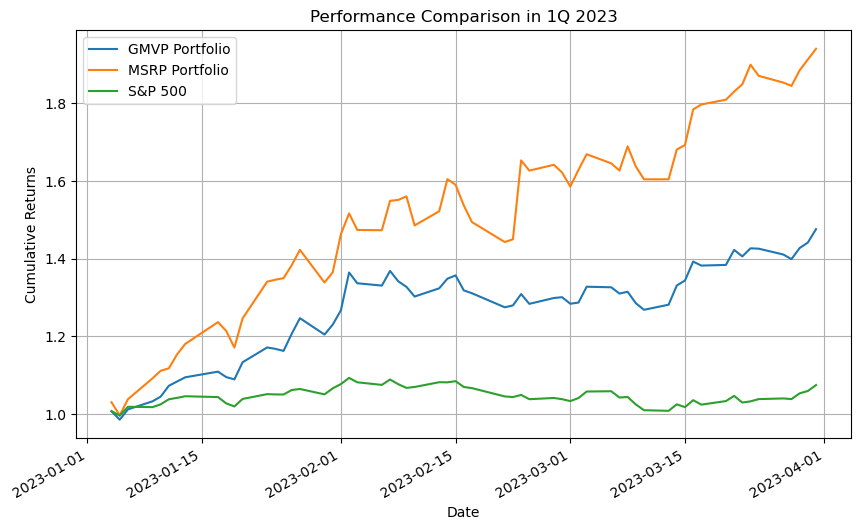

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
stocks = ['AAPL', 'AMZN', 'GOOGL','MSFT', 'META', 'NVDA','TSLA' ]
data = yf.download(stocks, start="2022-01-01", end="2023-01-01")['Close']
returns = data.pct_change().dropna()
cov_matrix = returns.cov()
expected_returns = returns.mean()
# 下载S&P 500数据作为基准
sp500 = yf.download('^GSPC', start="2023-01-01", end="2023-04-01")['Close']
sp500_returns = sp500.pct_change().dropna()
# 计算Global Minimum Variance Portfolio权重
from scipy.optimize import minimize
def minimize_volatility(weights): 
    return np.dot(weights.T, np.dot(cov_matrix, weights))
initial_weights = [1./len(stocks)] * len(stocks)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = tuple((0, 1) for asset in range(len(expected_returns)))
solution = minimize(minimize_volatility, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
gmvp_weights = solution.x
# 计算Maximum Sharpe Ratio Portfolio权重
Rf = 0.02
def negative_sharpe_ratio(weights): 
    portfolio_return = np.dot(expected_returns, weights)
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(portfolio_return - Rf) / portfolio_vol
solution = minimize(negative_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
msrp_weights = solution.x
# 计算2023年的投资组合和S&P 500的日收益率
data_2023 = yf.download(stocks, start="2023-01-01", end="2023-04-01")['Close']
returns_2023 = data_2023.pct_change().dropna()
gmvp_returns_2023 = np.dot(returns_2023, gmvp_weights)
msrp_returns_2023 = np.dot(returns_2023, msrp_weights)

print(f"GMVP 1Q 2023 Returns: {np.sum(gmvp_returns_2023):.2%}")
print(f"MSRP 1Q 2023 Returns: {np.sum(msrp_returns_2023):.2%}")
print(f"S&P 500 1Q 2023 Returns: {sp500_returns.sum():.2%}")

# 计算2023年的累积收益率
cumulative_gmvp_returns = (1 + gmvp_returns_2023).cumprod()
cumulative_msrp_returns = (1 + msrp_returns_2023).cumprod()
cumulative_sp500_returns = (1 + sp500_returns).cumprod()
# 对齐时间轴以进行绘图
all_returns = pd.DataFrame({
    "GMVP Portfolio": cumulative_gmvp_returns,
    "MSRP Portfolio": cumulative_msrp_returns,
    "S&P 500": cumulative_sp500_returns
})
plt.figure(figsize=(10, 6))
all_returns.plot(ax=plt.gca())
plt.title("Performance Comparison in 1Q 2023")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# 下载股票数据
tickers = ["AAPL", "AMZN", "GOOGL", "MSFT", "META", "NVDA", "TSLA"]
start_date = "2022-12-26" # 开始日期修改为2022-12-26，以便预测2023-01-02的最佳股票
end_date = "2023-04-01"
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
# 数据预处理
scaler = MinMaxScaler()
scaled_data = {}
for ticker in tickers:
    scaled_data[ticker] = pd.DataFrame()
    scaled_data[ticker]["Scaled_Close"] = scaler.fit_transform(data[[ticker]])[:, 0]
# 初始化BERT模型和tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
weekly_returns = {}
selected_stocks = {}
cumulative_return = 1
current_date = datetime.strptime("2023-01-02", '%Y-%m-%d') # 从2023年1月2日开始
while current_date < datetime.strptime(end_date, '%Y-%m-%d'):
    week_start = current_date
    week_end = current_date + timedelta(days=4)  # 周五的日期   
    # 如果周五是非交易日，使用下一个交易日的数据
    while week_end.strftime('%Y-%m-%d') not in data.index and week_end < datetime.strptime(end_date, '%Y-%m-%d'):
        week_end += timedelta(days=1)
    if week_end >= datetime.strptime(end_date, '%Y-%m-%d'):
        break   
    # 如果周五是非交易日，使用下一个交易日的数据
    while week_end.strftime('%Y-%m-%d') not in data.index:
        week_end += timedelta(days=1)   
    # 为每一只股票预测下周的收盘价
    predicted_returns = {}
    for ticker, df in scaled_data.items():
        if len(df) >= 8:  # 至少需要8天的数据
            X_pred = tokenizer(" ".join(df["Scaled_Close"].iloc[-7:].astype(str).tolist()), padding=True, truncation=True, return_tensors="tf", max_length=8)["input_ids"].numpy()
            predicted_close = model.predict(X_pred)
            predicted_logits = model.predict(X_pred).logits
            predicted_close = predicted_logits[0][0]  # 提取第一个预测值
            predicted_returns[ticker] = (predicted_close - df["Scaled_Close"].iloc[-1]) / df["Scaled_Close"].iloc[-1]    
    # 选择预测涨幅最大的股票
    best_ticker = max(predicted_returns, key=predicted_returns.get)
    selected_stocks[week_start] = best_ticker   
    # 计算实际收益率
    week_dates = pd.date_range(week_start, week_end)
    valid_dates = [date for date in week_dates if date.strftime('%Y-%m-%d') in data.index]   
    actual_open = data[best_ticker].loc[valid_dates[0].strftime('%Y-%m-%d')] if valid_dates else None
    actual_close = data[best_ticker].loc[valid_dates[-1].strftime('%Y-%m-%d')] if valid_dates else None
    weekly_return = actual_close / actual_open if actual_open and actual_close else 1.0
    weekly_returns[week_end] = weekly_return
    if weekly_return is not None:
        cumulative_return *= weekly_return
    # 更新数据和模型
    X, Y = [], []
    for _, df in scaled_data.items():
        for i in range(7, len(df)):
            X.append(" ".join(df["Scaled_Close"].iloc[i-7:i].astype(str).tolist()))
            Y.append(df["Scaled_Close"].iloc[i])
    X = tokenizer(X, padding=True, truncation=True, return_tensors="tf", max_length=8)["input_ids"].numpy()
    Y = np.array(Y)  
    model.fit(X, Y, epochs=3, batch_size=8, verbose=0)
    # 移至下一个周一
    current_date += timedelta(days=7)
print(f"Cumulative return until 2023-04-01: {cumulative_return - 1:.2%}")

[*********************100%***********************]  7 of 7 completed


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 47ms/step
Cumulative return until 2023-04-01: 32.59%


In [3]:
selected_stocks

{datetime.datetime(2023, 1, 2, 0, 0): 'META',
 datetime.datetime(2023, 1, 9, 0, 0): 'AMZN',
 datetime.datetime(2023, 1, 16, 0, 0): 'AMZN',
 datetime.datetime(2023, 1, 23, 0, 0): 'GOOGL',
 datetime.datetime(2023, 1, 30, 0, 0): 'GOOGL',
 datetime.datetime(2023, 2, 6, 0, 0): 'GOOGL',
 datetime.datetime(2023, 2, 13, 0, 0): 'GOOGL',
 datetime.datetime(2023, 2, 20, 0, 0): 'GOOGL',
 datetime.datetime(2023, 2, 27, 0, 0): 'GOOGL',
 datetime.datetime(2023, 3, 6, 0, 0): 'GOOGL',
 datetime.datetime(2023, 3, 13, 0, 0): 'GOOGL',
 datetime.datetime(2023, 3, 20, 0, 0): 'GOOGL',
 datetime.datetime(2023, 3, 27, 0, 0): 'GOOGL'}

In [4]:
start_date = "2023-01-01"
end_date = "2023-04-01"
snp500_data = yf.download("^GSPC", start=start_date, end=end_date)
from datetime import datetime, timedelta
start_date = datetime(2023, 1, 2)
end_date = datetime(2023, 7, 1)
date_ranges = []
current_date = start_date
while current_date < end_date:
    week_start = current_date
    week_end = week_start + timedelta(days=4)  # Assuming Friday is the end of the week
    date_ranges.append((week_start, week_end))
    current_date += timedelta(days=7)
# 将数据的索引（日期）转为datetime格式，确保后续处理时它是日期格式
snp500_data.index = pd.to_datetime(snp500_data.index)
snp500_weekly_returns = {}
for week_start, week_end in date_ranges:
    # 检查开始日期是否在数据中，如果不在，则尝试后续日期
    while week_start not in snp500_data.index and week_start < week_end:
        week_start += timedelta(days=1)  
    # 检查结束日期是否在数据中，如果不在，则尝试之前的日期
    while week_end not in snp500_data.index and week_end > week_start:
        week_end -= timedelta(days=1)
    if week_start in snp500_data.index and week_end in snp500_data.index:
        open_price = snp500_data.loc[week_start]['Open']
        close_price = snp500_data.loc[week_end]['Close']
        snp500_weekly_returns[week_end] = (close_price - open_price) / open_price
# 计算累计收益率
cumulative_returns_sp500 = [(1 + return_val) for return_val in snp500_weekly_returns.values()]
for i in range(1, len(cumulative_returns_sp500)):
    cumulative_returns_sp500[i] *= cumulative_returns_sp500[i - 1]  
cumulative_returns_sp500.insert(0, 1)  # 为了使图的起始点为1

[*********************100%***********************]  1 of 1 completed


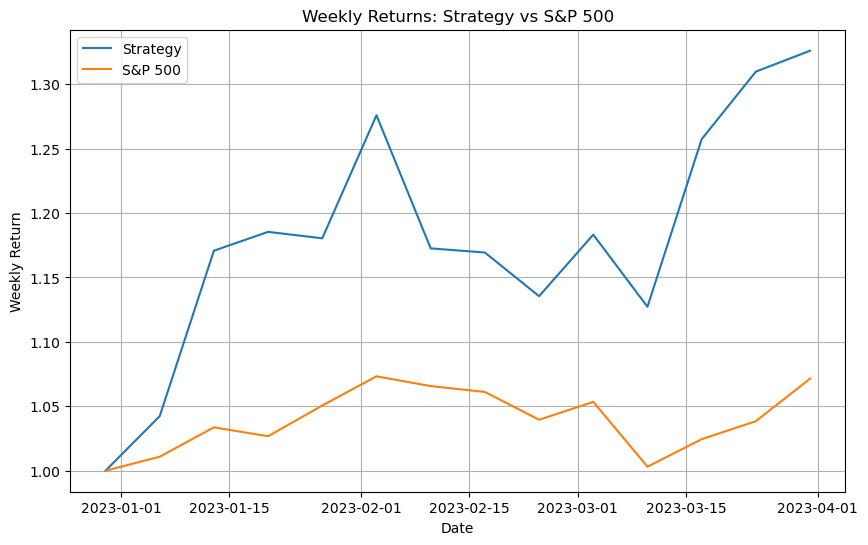

In [5]:
import matplotlib.pyplot as plt
# 使用之前的代码得到你的策略的每周收益率：weekly_returns
# 使用之前的代码得到S&P 500的每周收益率：snp500_weekly_returns
dates = list(weekly_returns.keys())
# 计算累计收益率
cumulative_returns = [1]
for date in sorted(weekly_returns.keys()):
    cumulative_returns.append(cumulative_returns[-1] * weekly_returns[date])  
dates = list(sorted(weekly_returns.keys()))
dates.insert(0, dates[0] - timedelta(days=7))  # 为了使图的起始点为1
plt.figure(figsize=(10, 6))
plt.plot(dates, cumulative_returns, label="Strategy")
plt.plot(dates, cumulative_returns_sp500, label="S&P 500")
plt.legend()
plt.title("Weekly Returns: Strategy vs S&P 500")
plt.xlabel("Date")
plt.ylabel("Weekly Return")
plt.grid(True)
plt.show()